We first install and import necessary packages.

In [ ]:
!pip install torch
!pip install gymnasium
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as functional

import matplotlib.pyplot as plt

## Acrobot

Next, we instantiate the [Acrobot environment](https://www.gymlibrary.dev/environments/classic_control/acrobot/) from OpenAI Gym and gain a quick understanding of its key variables and methods.

The Acrobot environment includes a simple robot with two blue links that are connected by two green joints. The joint connecting the two links is actuated, i.e., it can be controlled by the robot by applying torque to the joint. The goal is to swing the free end of the outer link to reach the target height (shown as the black horizontal line) by using robot's actuation.

Follow the hyperlinks to learn more about the envionment [Acrobot environment](https://www.gymlibrary.dev/environments/classic_control/acrobot/)  and its [source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py).

![](https://www.gymlibrary.dev/_images/acrobot.gif)

In [ ]:
env = gym.make("Acrobot-v1")

#### States

OpenAI Gym environments do not explicitly provide state but instead provide observation. In the Acrobot environment, the state and observation are identical. The state of the Acrobot is a 6-dimensional vector, which provides information about the two rotational joint angles of the robot and their angular velocities. As joint angles and velocity are continuous variables, so is the Acrobot state.

In [ ]:
print(f"Number of state features: {env.observation_space.shape[0]}")

Number of state features: 6


#### Actions

In contrast to the continuous state, the action space for this robot is discrete. The robot has only three choices:
- apply torque of unit 1 in clockwise direction,
- apply torque of until 1 in counter-clockwise direction, or
- apply no torque.

In [ ]:
print(f"Number of actions: {env.action_space.n}")

Number of actions: 3


#### Transition and Reward Function

The transition and rewards functions for the environment are not explicitly represented as matrices or tensors. Instead the gym API provides access to the `step` method, which takes in as input an `action` and provides (among other things) an `observation` and `reward`. Also notice the `reset` method, which resets the MDP environment.

The following snippet describes the use of `step` and `reset` methods.

In [ ]:
# Reset the environment
state = env.reset()
print(f"State: {state}")

# Select a random action to play
action = env.action_space.sample()
print(f"Action: {action}")

# Send this action to the environment to receive the next state and reward
next_state, reward, done, _, _ = env.step(action)
print(f"Next state: {next_state}")
print(f"Reward: {reward}")

State: (array([ 0.99966305, -0.02595667,  0.9983299 ,  0.05777071, -0.00446958,
       -0.01471536], dtype=float32), {})
Action: 2
Next state: [ 0.99935657 -0.03586657  0.9967326   0.08077235 -0.09178696  0.23946333]
Reward: -1.0


## Problem 1.1

Next, we will implement the general recipe of Q Learning algorithm to compute the optimal policy in the Acrobot environment.

#### Q Network

Since, the robot's state space is continuous, we cannot represent the Q value function exactly. Instead, we will approximate the Q value as a neural network. Let us first define this neural network.

Many choices exist for the neural network architecture. We will utilize a multi-layer perceptron, with
- input as the state of the Acrobot, and
- output as a vector of size 3 denoting Q values of each action for the input state.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class QNetwork(nn.Module):
    """Approximates the Q Function as a Multi-Layer Perceptron."""

    def __init__(self, env, nodes_per_mlp_layer=[128, 64]):
        """Initialize the Q Function apprixmated as a Multi-Layer Perceptron.

        Args:
            env: An OpenAI Gym environment.
            nodes_per_mlp_layer: An array of integers. The length of array equals the number
                of hidden layers of the Multi-Layer Perceptron. Each element in the array
                equals the number of nodes in the corresponding layer.
        """
        super().__init__()

        ######## PUT YOUR CODE HERE ########
        # input layer
        self.input_layer = nn.LazyLinear(nodes_per_mlp_layer[0])

        # hidden layers
        self.hidden_layers = nn.ModuleList()
        for k in range(len(nodes_per_mlp_layer) - 1):
            self.hidden_layers.append(nn.LazyLinear(nodes_per_mlp_layer[k+1]))

        # output layer
        self.output_layer = nn.LazyLinear(env.action_space.n)
        ######## PUT YOUR CODE HERE ########

    def forward(self, x):
        """Implements the forward pass of the Q Network.

        Args:
            x: Input to the Q Network.

        Returns:
            Output of the Q Network.
        """
        ######## PUT YOUR CODE HERE ########
        # print(x)
        x = self.input_layer(x)
        # print(x)
        x = torch.relu(x)
        for hl in range(len(self.hidden_layers)):
          x = self.hidden_layers[hl](x)
          # print(hl, x)
          x = torch.relu(x)
        # print(x)
        x = self.output_layer(x)
        # print("preoutput", x)
        return x
        ######## PUT YOUR CODE HERE ########

#### Replay Buffer

In addition to the Q Network, our algorithm requires a data structure to store the agent's experiences: Replay Buffer. Let us now define this data structure.

Similar to Q Network, many data structure choices exist for the Replay Buffer. We will use a simple buffer to store agent's experiences.

In [ ]:
class ReplayBuffer:
    """A buffer to store agent's experiences."""

    def __init__(self, env, buffer_size):
        """Initialize a ring buffer to store agent's experiences.

        Args:
            env: An OpenAI Gym environment.
            buffer_size: An integer. The total size of the buffer.
        """
        observation_n = env.observation_space.shape[0]
        self.buffer_size = buffer_size

        self.observations = np.zeros((self.buffer_size, observation_n), dtype=np.float32)
        self.next_observations = np.zeros((self.buffer_size, observation_n), dtype=np.float32)
        self.actions = np.zeros((self.buffer_size,), dtype=np.int64)
        self.rewards = np.zeros((self.buffer_size,), dtype=np.float32)
        self.dones = np.zeros((self.buffer_size,), dtype=np.float32)

        ######## PUT YOUR CODE HERE ########
        self.position = 0
        self.size = 0
        ######## PUT YOUR CODE HERE ########

    def add(self, state, action, next_state, reward, done):
        """Add an experience to the buffer.

        Args:
            state: the current environment state
            action: the action executed in the state
            next_state: the state after executing the action
            reward: the reward received after executing the action
            done: Boolean denoting whether the task is completed.
        """
        ######## PUT YOUR CODE HERE ########
        self.observations[self.position] = state
        self.next_observations[self.position] = next_state
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.dones[self.position] = done
        self.position += 1
        if self.position == self.buffer_size:
          self.position = 0
        if self.size < self.buffer_size:
          self.size += 1
        ######## PUT YOUR CODE HERE ########

    def sample(self, batch_size):
        """Sample a mini-batch of experiences from the replay buffer.

        Args:
            batch_size: An integer. The size of the mini-batch.

        Returns:
            Randomly sampled experiences from the replay buffer.
        """
        indices = np.random.randint(self.size, size=batch_size)
        observations = torch.from_numpy(self.observations[indices]).to(device)
        next_observations = torch.from_numpy(self.next_observations[indices]).to(device)
        actions = torch.from_numpy(self.actions[indices]).to(device)
        rewards = torch.from_numpy(self.rewards[indices]).to(device)
        dones = torch.from_numpy(self.dones[indices]).to(device)

        return observations, actions, next_observations, rewards, dones

#### Exploration schedule

Q Learning typically utilizes epsilon-greedy strategy for exploration.

In general, it is useful to explore more initially (when the agent is far from the optimal policy) and less later on in the learning process. To implement this, we can implement a schedule for epsilon.

Similar to the Q network and replay buffer architectures, several choices exist for determining the epsilon schedule. We will use a simple linear scheduler to decay epsilon as agent gains more experience.

In [ ]:
def linear_schedule_for_epsilon(initial_value, final_value, duration, timestep):
    """Implements a linear scheduler for epsilon.

    Args:
        initial_value: (float) Initial value of epsilon.
        final_value: (float) Final value of epsilon.
        duration: (int) Duration over which to decay epsilon from its initial to final value.
        timestep: (int) The current time step.

    Returns:
        Value of epsilon at the given timestep.
    """
    slope = (final_value - initial_value) / duration
    return max(slope * timestep + initial_value, final_value)

#### General recipe for Q Learning with Function Approximation

Now that we have all the building blocks, we will implement the general recipe for Q learning with function approximation.

We will use the AgentBase class from Assignment 2 to help us with the implementation.

In [ ]:
class AgentBase:
    def __init__(self, env):
        self.env = env
        self.num_actions = self.env.action_space.n
        self.policy = self.make_policy()
        self.behavior_policy = self.make_behavior_policy()

    def make_policy(self):
        """
        Return a policy function that will be used for evaluation. The policy
        takes observation as input and return action
        """
        raise NotImplementedError

    def make_behavior_policy(self):
        """
        Similar to make_policy, it returns a policy function. But this one used
        for interaction with the environment.
        """
        raise NotImplementedError

    def run_episode(self, episode_policy):
        """
        Generate one episode with the given policy
        """
        episode = []
        done = False
        obs = self.env.reset()[0]
        episode_return = 0
        while not done:
            action = episode_policy(obs)
            next_obs, reward, done, truncated, _ = self.env.step(action)
            done = done or truncated
            episode.append([obs, action, reward, next_obs, done])
            obs = next_obs
            episode_return += reward

        return (episode, episode_return)

    def evaluate(self, num_eval_episodes=1000, plot_title="Evaluation"):
        """Evaluates the agent."""
        list_returns = []
        list_average_returns = []
        average_return = 0
        for episode_idx in range(num_eval_episodes):
            _, episode_return = self.run_episode(self.policy)
            average_return += (1. / (episode_idx+1)) * (episode_return - average_return)
            list_returns.append(episode_return)
            list_average_returns.append(average_return)

        print(f"Average reward {round(average_return, 3)}")
        plt.plot(list_returns,'^',label="Return")
        plt.plot(list_average_returns,'r',label="Average Return")
        plt.ylabel('Return')
        plt.xlabel('Episode#')
        plt.title(plot_title)
        plt.legend()
        plt.ylim(-501, 0.0)
        plt.show()

In [199]:
class DeepQLearning(AgentBase):
    """Implements a Q Learner with function approximation."""

    def __init__(self,
        env,
        buffer_size = 200000,
        batch_size = 64,
        initial_epsilon = 1.0,
        final_epsilon = 0.01,
        epsilon_decay_duration = 100000,
        learning_rate = 0.001,
        num_gradient_updates = 1,
        q_network_update_frequency = 1,
        target_network_update_frequency = 200,
        learning_starts_at_step = 10000):
        """Initializes the Agent.

        Args:
            env: An OpenAI Gym environment.
            buffer_size: (integer) Size of the replay buffer.
            batch_size: (integer) Size of the mini batch.
            initial_epsilon: (float) Initial value of epsilon.
            final_epsilon: (float) Final value of epsilon.
            epsilon_decay_duration: (integer) Duration over which to decay epsilon.
            learning_rate: (float) Learning rate for Q network update.
            num_gradient_updates: (integer) Number of stochastic gradient updates with each minibatch.
            q_network_update_frequency: (integer) Steps after which to update Q network.
            target_network_update_frequency: (integer) Steps after which to update target network.
            learning_starts_at_step: (integer) Step at which to begin learning. Before this, the
                agent explores and collects experiences in its replay buffer.
        """
        super().__init__(env=env)

        self.initial_epsilon = 1.0,
        self.final_epsilon = 0.01,

        self.gamma = 0.99 # Assume a discount factor of 0.99
        self.current_step = 0
        self.learning_starts_at_step = learning_starts_at_step
        self.batch_size = batch_size
        self.num_gradient_updates = num_gradient_updates
        self.q_network_update_frequency = q_network_update_frequency
        self.target_network_update_frequency = target_network_update_frequency

        # Create exploration scheduler
        self.epsilon_scheduler = lambda current_step: linear_schedule_for_epsilon(
            initial_epsilon, final_epsilon, epsilon_decay_duration, current_step)

        ######## PUT YOUR CODE HERE ########
        self.replay_buffer = ReplayBuffer(env, buffer_size)
        self.q_network = QNetwork(env).to(device)
        self.q_target = QNetwork(env).to(device) # policy network: will act according to these Qs while receiving info from the other Q
        self.learning_rate = learning_rate
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        ######## PUT YOUR CODE HERE ########

        self.state = env.reset()[0]
        self.list_returns = []
        self.list_average_returns = []
        self.average_return = 0.
        self.list_moving_average_returns = []
        self.moving_average_returns_by_step = np.empty([200000])

    @property
    def epsilon(self):
        return self.epsilon_scheduler(self.current_step)

    def make_policy(self):
        def policy_func(observation):
            # print(observation.shape)
            ######## PUT YOUR CODE HERE ########
            # just pick the one that the "largest q" model spits out
            # print(self.q_target(torch.from_numpy(observation)))
            # print(self.q_target)
            optimal_action = torch.argmax(self.q_target(torch.from_numpy(observation).to(device)))
            return optimal_action
            ######## PUT YOUR CODE HERE ########

        return policy_func

    def make_behavior_policy(self):
        def policy_func(observation):
            ######## PUT YOUR CODE HERE ########
            # do same as above but epsilon greedy
            optimal_action = torch.argmax(self.q_target(torch.from_numpy(observation).to(device)))
            # random here is a random number in {-1, 0, 1}
            return optimal_action if torch.rand((1)) > self.epsilon else torch.round(torch.rand((1))*2-1)
            ######## PUT YOUR CODE HERE ########

        return policy_func

    def update(self):

        # whoopsies!
        if self.current_step < self.learning_starts_at_step or self.current_step % self.q_network_update_frequency != 0:
            return
        loss_fn = nn.MSELoss() #+ 0.0001 * torch.norm(self.q_network.parameters())

        self.q_network.train()
        observations, actions, next_observations, rewards, dones = self.replay_buffer.sample(self.batch_size)
        g = rewards + (1-dones) * torch.mul(torch.max(self.q_target(next_observations), dim=1)[0], self.gamma)
        #print(actions.unsqueeze(1), self.q_network(observations), g.unsqueeze(1))
        actunsqueeze = actions.unsqueeze(1)
        actunsqueeze[actunsqueeze==-1] = 2

        loss = loss_fn(torch.gather(self.q_network(observations), 1, actunsqueeze), g.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()


        for i in range(self.num_gradient_updates):
            self.optimizer.step()


        # update target network
        if self.target_network_update_frequency > 0:
          if self.current_step % self.target_network_update_frequency == 0:
            # update target to become q
            self.q_target.load_state_dict(self.q_network.state_dict())
        ######## PUT YOUR CODE HERE ########


    def train(self, num_train_episodes, make_plot=False, show_instant=1):

        for episode_idx in range(num_train_episodes):
            # Reset environment before beginning the episode
            done = False
            self.state = self.env.reset()[0]
            episode_return = 0

            # Run the episode and update the policy
            while not done:
                # First, generate a step with behavior policy
                action = self.behavior_policy(self.state)
                # print(action)
                next_state, reward, done, truncated, _ = self.env.step(action.type(torch.int64))
                done = done or truncated

                # Update the replay buffer
                self.replay_buffer.add(self.state, action, next_state, reward, done)

                # Second, update the agent
                self.update()

                # Prepare for next step
                self.state = next_state
                self.current_step += 1
                episode_return += reward
                if self.current_step < 200000:
                    if len(self.list_moving_average_returns) > 0:
                      self.moving_average_returns_by_step[self.current_step] = self.list_moving_average_returns[-1]
                    else:
                      self.moving_average_returns_by_step[self.current_step] = -500.

                if self.current_step % 10000 == 0:
                    print(f"Timestep: {self.current_step}, episode reward (moving average, 20 episodes): {round(self.list_moving_average_returns[-1],2)}")

            # Store the return for evaluation
            self.list_returns.append(episode_return)
            self.average_return = np.mean(np.asarray(self.list_returns))
            self.list_average_returns.append(self.average_return)

            if len(self.list_returns) > 20:
                self.list_moving_average_returns.append(
                  np.mean(np.asarray(self.list_returns[-20:])))
            else:
                self.list_moving_average_returns.append(self.average_return)

        if make_plot:
            self.make_plot(show_instant)

    def make_plot(self, show_returns=1, show_avgret=1, show_movavg=1, default_scheme=1, listret_color='^', avgret_color='r', movavg_color='b', show_instant=0, model_label="Base DQN"):
        if show_returns:
          plt.plot(self.list_returns,'^' if default_scheme else listret_color,label="Return")
        if show_avgret:
          plt.plot(self.list_average_returns,'r' if default_scheme else avgret_color,label="Average Return (all episodes)")
        if show_movavg:
          plt.plot(self.list_moving_average_returns,'b' if default_scheme else movavg_color,label="Average Return (last 20 episodes), " + model_label)
        plt.ylabel('Return')
        plt.xlabel('Episode#')
        plt.title('Performance during training')
        plt.ylim(-501, 0.0)
        plt.legend()
        if show_instant:
          plt.show()

    def copy_params(self, other_DQL, initvars=1, train_prog=1, data=1, results=1):
      # copy other_DQL's params to this one
      if initvars:
        self.gamma = other_DQL.gamma
        self.learning_starts_at_step = other_DQL.learning_starts_at_step
        self.batch_size = other_DQL.batch_size
        self.num_gradient_updates = other_DQL.num_gradient_updates
        self.q_network_update_frequency = other_DQL.q_network_update_frequency
        self.target_network_update_frequency = other_DQL.target_network_update_frequency

      if train_prog:
        self.current_step = other_DQL.current_step
        self.epsilon_scheduler = other_DQL.epsilon_scheduler

      if data:
        self.replay_buffer = other_DQL.replay_buffer
        self.q_network = other_DQL.q_network
        self.q_target = other_DQL.q_target
        self.learning_rate = other_DQL.learning_rate
        self.loss_fn = other_DQL.loss_fn
        self.optimizer = other_DQL.optimizer

      if results:
        self.state = other_DQL.state
        self.list_returns = other_DQL.list_returns
        self.list_average_returns = other_DQL.list_average_returns
        self.average_return = other_DQL.average_return
        self.list_moving_average_returns = other_DQL.list_moving_average_returns
        self.moving_average_returns_by_step = other_DQL.moving_average_returns_by_step


In [ ]:
qn = QNetwork(env)
print(qn)

QNetwork(
  (input_layer): LazyLinear(in_features=0, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
  )
  (output_layer): LazyLinear(in_features=0, out_features=3, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
print(qn(torch.tensor([.5, .5, .5, .5, .5, .5])))

tensor([-0.0037,  0.0503,  0.0712], grad_fn=<ViewBackward0>)


#### Training the Agent

Having implemented the agent, now we will train it using the default hyperparameters provided in the class definition and observe its performance.

In [ ]:
env = gym.make("Acrobot-v1")
agent_001 = DeepQLearning(env)

Average reward -500.0


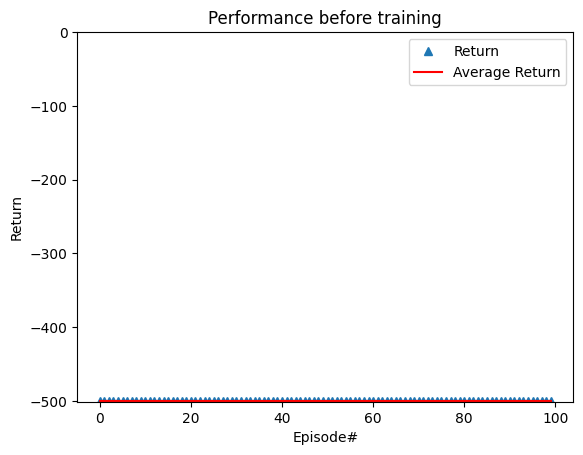

In [ ]:
agent_001.evaluate(plot_title="Performance before training", num_eval_episodes=100)

Timestep: 10000, episode reward (moving average, 20 episodes): -491.25
Timestep: 20000, episode reward (moving average, 20 episodes): -462.1
Timestep: 30000, episode reward (moving average, 20 episodes): -248.7
Timestep: 40000, episode reward (moving average, 20 episodes): -203.75
Timestep: 50000, episode reward (moving average, 20 episodes): -161.6
Timestep: 60000, episode reward (moving average, 20 episodes): -155.15
Timestep: 70000, episode reward (moving average, 20 episodes): -114.5
Timestep: 80000, episode reward (moving average, 20 episodes): -105.15
Timestep: 90000, episode reward (moving average, 20 episodes): -93.75
Timestep: 100000, episode reward (moving average, 20 episodes): -88.65
Timestep: 110000, episode reward (moving average, 20 episodes): -82.75
Timestep: 120000, episode reward (moving average, 20 episodes): -79.65
Timestep: 130000, episode reward (moving average, 20 episodes): -86.85


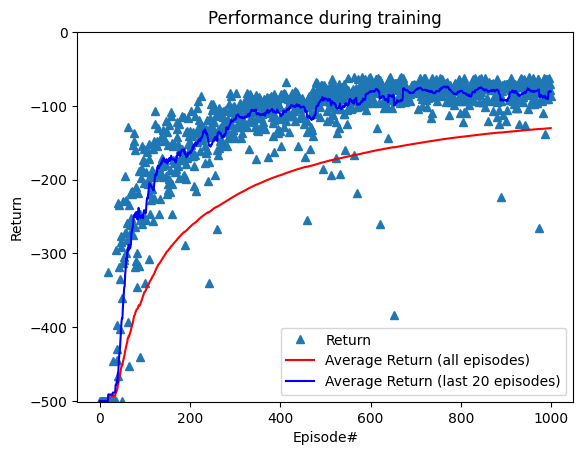

In [ ]:
agent_001.train(1000, make_plot=True)

Average reward -80.06


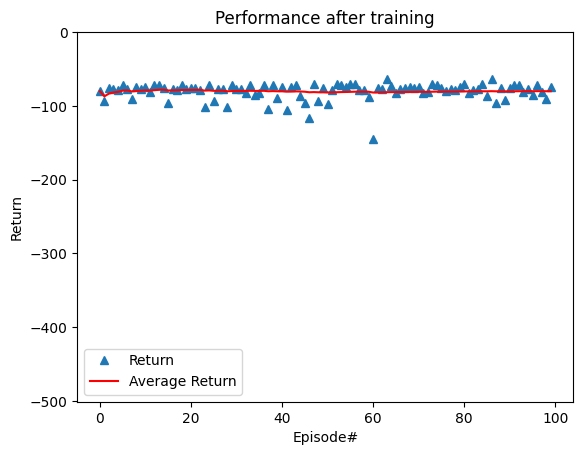

In [ ]:
agent_001.evaluate(plot_title="Performance after training", num_eval_episodes=100)

## Problem 1.2

Now that we have implemented the general recipe, let us run ablation studies to assess importance of different components of the Deep Q Learning algorithm.

First, we will implement and assess the performance of the original Q Learning with naive function approximation, i.e., without the use of replay buffer and target networks. Note that this is a special case of our general recipe and, in general, we do not expect to work in practice. Let us see if it works for the Acrobot environment.

In [194]:
class OnlineDeepQLearning(DeepQLearning):
    """Implements Online Q Learner with function approximation."""

    ######## PUT YOUR CODE HERE ########
    def __init__(self,
        env,
        #buffer_size = 200000,
        batch_size = 64,
        initial_epsilon = 1.0,
        final_epsilon = 0.01,
        epsilon_decay_duration = 100000,
        learning_rate = 0.001,
        num_gradient_updates = 1,
        q_network_update_frequency = 1,
        #target_network_update_frequency = 200,
        learning_starts_at_step = 10000):
      super().__init__(env,
        buffer_size = 1,
        batch_size = 64,
        initial_epsilon = 1.0,
        final_epsilon = 0.01,
        epsilon_decay_duration = 100000,
        learning_rate = 0.001,
        num_gradient_updates = 1,
        q_network_update_frequency = 1,
        target_network_update_frequency = 0,
        learning_starts_at_step = 10000)
    ######## PUT YOUR CODE HERE ########

    def make_plot(self, show_returns=1, show_avgret=1, show_movavg=1, default_scheme=1, listret_color='^', avgret_color='r', movavg_color='b', show_instant=0, model_label="Online"):
      super().make_plot(show_returns, show_avgret, show_movavg, default_scheme, listret_color, avgret_color, movavg_color, show_instant, model_label)

    def copy_params(self, other_DQL, initvars=1, train_prog=1, data=1, results=1):
      super().copy_params(other_DQL, initvars, train_prog, data, results)

In [ ]:
env = gym.make("Acrobot-v1")
agent_002 = OnlineDeepQLearning(env)

Timestep: 10000, episode reward (moving average, 20 episodes): -486.7
Timestep: 20000, episode reward (moving average, 20 episodes): -495.7
Timestep: 30000, episode reward (moving average, 20 episodes): -475.3
Timestep: 40000, episode reward (moving average, 20 episodes): -455.8
Timestep: 50000, episode reward (moving average, 20 episodes): -478.7
Timestep: 60000, episode reward (moving average, 20 episodes): -474.9
Timestep: 70000, episode reward (moving average, 20 episodes): -457.8
Timestep: 80000, episode reward (moving average, 20 episodes): -468.45
Timestep: 90000, episode reward (moving average, 20 episodes): -490.65
Timestep: 100000, episode reward (moving average, 20 episodes): -499.15
Timestep: 110000, episode reward (moving average, 20 episodes): -500.0
Timestep: 120000, episode reward (moving average, 20 episodes): -500.0
Timestep: 130000, episode reward (moving average, 20 episodes): -500.0
Timestep: 140000, episode reward (moving average, 20 episodes): -500.0
Timestep: 15

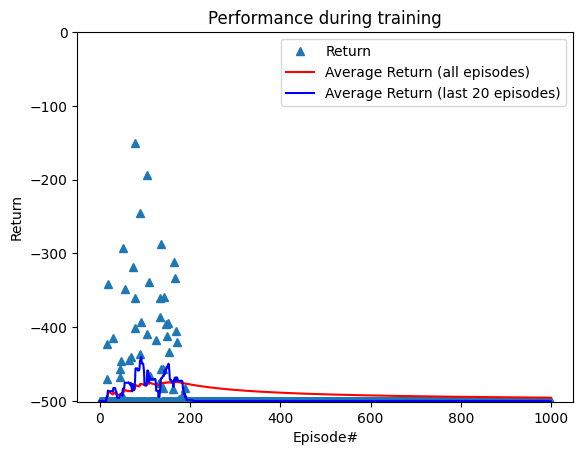

In [ ]:
agent_002.train(1000, make_plot=True)

In [ ]:
# EVALUATION:
# This algorithm does not update the target network, and only learns based on changing the expected reward for each state-action pair given by the q network.
# This algorithm also does not make use of a replay buffer, only learning from the datapoint it saw immediately prior.
# These two factors combined make the network unable to gather enough data for any given policy before switching policy, causing the performance to be unstable.

Now let us bring back one of the components at a time that made the algorithm successful in Problem 1. First, we will bring back only the replay buffer (and not the target network) and observe its effect on the agent's performance.

In [195]:
class DeepQLearningWithoutTargetNetwork(DeepQLearning):
    """Implements a Deep Q Learner without target network."""

    ######## PUT YOUR CODE HERE ########
    def __init__(self,
        env,
        buffer_size = 200000,
        batch_size = 64,
        initial_epsilon = 1.0,
        final_epsilon = 0.01,
        epsilon_decay_duration = 100000,
        learning_rate = 0.001,
        num_gradient_updates = 1,
        q_network_update_frequency = 1,
        #target_network_update_frequency = 200,
        learning_starts_at_step = 10000):
      super().__init__(env,
        buffer_size = 200000,
        batch_size = 64,
        initial_epsilon = 1.0,
        final_epsilon = 0.01,
        epsilon_decay_duration = 100000,
        learning_rate = 0.001,
        num_gradient_updates = 1,
        q_network_update_frequency = 1,
        target_network_update_frequency = 0,
        learning_starts_at_step = 10000)
    ######## PUT YOUR CODE HERE ########

    def make_plot(self, show_returns=1, show_avgret=1, show_movavg=1, default_scheme=1, listret_color='^', avgret_color='r', movavg_color='b', show_instant=0, model_label="NoTarget"):
      super().make_plot(show_returns, show_avgret, show_movavg, default_scheme, listret_color, avgret_color, movavg_color, show_instant, model_label)

    def copy_params(self, other_DQL, initvars=1, train_prog=1, data=1, results=1):
      super().copy_params(other_DQL, initvars, train_prog, data, results)

In [ ]:
env = gym.make("Acrobot-v1")
agent_003 = DeepQLearningWithoutTargetNetwork(env)

Timestep: 10000, episode reward (moving average, 20 episodes): -500.0
Timestep: 20000, episode reward (moving average, 20 episodes): -463.4
Timestep: 30000, episode reward (moving average, 20 episodes): -421.5
Timestep: 40000, episode reward (moving average, 20 episodes): -347.5
Timestep: 50000, episode reward (moving average, 20 episodes): -342.95
Timestep: 60000, episode reward (moving average, 20 episodes): -237.4
Timestep: 70000, episode reward (moving average, 20 episodes): -217.0
Timestep: 80000, episode reward (moving average, 20 episodes): -195.95
Timestep: 90000, episode reward (moving average, 20 episodes): -172.5
Timestep: 100000, episode reward (moving average, 20 episodes): -151.7
Timestep: 110000, episode reward (moving average, 20 episodes): -140.75
Timestep: 120000, episode reward (moving average, 20 episodes): -149.1
Timestep: 130000, episode reward (moving average, 20 episodes): -150.35
Timestep: 140000, episode reward (moving average, 20 episodes): -160.55
Timestep: 

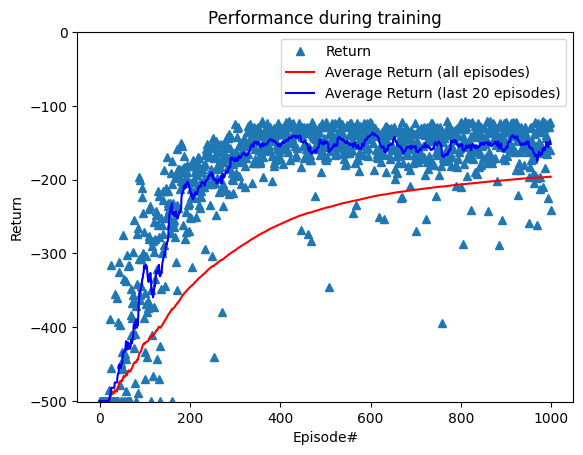

In [ ]:
agent_003.train(1000, make_plot=True)

In [ ]:
# EVALUATION
# While this agent is still able to learn by purely updaating Q network and not have a target network,
# we see that performance has degraded due to not being able to stay on one policy for long to collect data before moving onto another policy.
# However, since this task was simple enough? the agent still learns some satisfactory performance that converges.

Next, we will bring back only the target network (and not the replay buffer) and observe its effect on the agent's performance.

In [196]:
class DeepQLearningWithoutReplayBuffer(DeepQLearning):
    """Implements a Deep Q Learner without replay buffer."""
    ######## PUT YOUR CODE HERE ########
    def __init__(self,
        env,
        #buffer_size = 200000,
        batch_size = 64,
        initial_epsilon = 1.0,
        final_epsilon = 0.01,
        epsilon_decay_duration = 100000,
        learning_rate = 0.001,
        num_gradient_updates = 1,
        q_network_update_frequency = 1,
        target_network_update_frequency = 200,
        learning_starts_at_step = 10000):
      super().__init__(env,
        buffer_size = 1,
        batch_size = 64,
        initial_epsilon = 1.0,
        final_epsilon = 0.01,
        epsilon_decay_duration = 100000,
        learning_rate = 0.001,
        num_gradient_updates = 1,
        q_network_update_frequency = 1,
        target_network_update_frequency = 200,
        learning_starts_at_step = 10000)
    ######## PUT YOUR CODE HERE ########

    def make_plot(self, show_returns=1, show_avgret=1, show_movavg=1, default_scheme=1, listret_color='^', avgret_color='r', movavg_color='b', show_instant=0, model_label="No Buffer"):
      super().make_plot(show_returns, show_avgret, show_movavg, default_scheme, listret_color, avgret_color, movavg_color, show_instant, model_label)

    def copy_params(self, other_DQL, initvars=1, train_prog=1, data=1, results=1):
      super().copy_params(other_DQL, initvars, train_prog, data, results)

In [ ]:
env = gym.make("Acrobot-v1")
agent_004 = DeepQLearningWithoutReplayBuffer(env)

Timestep: 10000, episode reward (moving average, 20 episodes): -493.25
Timestep: 20000, episode reward (moving average, 20 episodes): -474.45
Timestep: 30000, episode reward (moving average, 20 episodes): -388.05
Timestep: 40000, episode reward (moving average, 20 episodes): -288.5
Timestep: 50000, episode reward (moving average, 20 episodes): -219.5
Timestep: 60000, episode reward (moving average, 20 episodes): -203.0
Timestep: 70000, episode reward (moving average, 20 episodes): -204.4
Timestep: 80000, episode reward (moving average, 20 episodes): -150.0
Timestep: 90000, episode reward (moving average, 20 episodes): -175.0
Timestep: 100000, episode reward (moving average, 20 episodes): -224.55
Timestep: 110000, episode reward (moving average, 20 episodes): -250.05
Timestep: 120000, episode reward (moving average, 20 episodes): -371.95
Timestep: 130000, episode reward (moving average, 20 episodes): -500.0
Timestep: 140000, episode reward (moving average, 20 episodes): -500.0
Timestep:

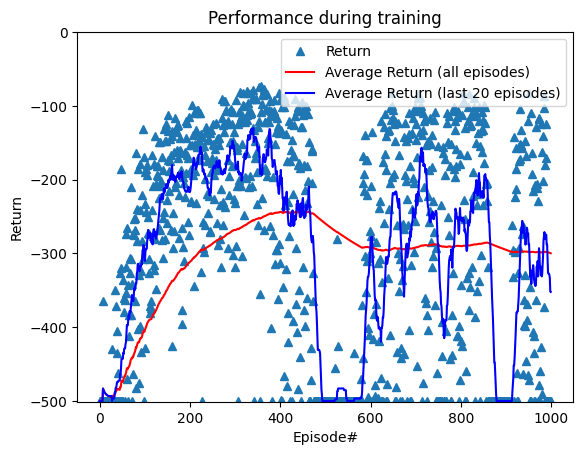

In [ ]:
agent_004.train(1000, make_plot=True)

In [ ]:
# EVALUATION
# Here we see the agent only learning with the datapoint it last saw. As a result, its training data is correlated,
# so the information about the state/action it is learning very much depends on what it last saw, creating very unstable training, even if it can converge at times.

In a single plot, show the performance of the four variants that you have implemented above. Specifications of the plot
- X axis: Number of Timesteps (0 to 100000)
- Y axis: 20-episode simple moving average of episodic rewards.

In [200]:
# port trained networks to version with copy and plot function -- and to evaluate on fresh env
env = gym.make("Acrobot-v1")
temp = DeepQLearning(env)
temp.copy_params(agent_001)
agent_001 = temp

temp = OnlineDeepQLearning(env)
temp.copy_params(agent_002)
agent_002 = temp

temp = DeepQLearningWithoutTargetNetwork(env)
temp.copy_params(agent_003)
agent_003 = temp

temp = DeepQLearningWithoutReplayBuffer(env)
temp.copy_params(agent_004)
agent_004 = temp

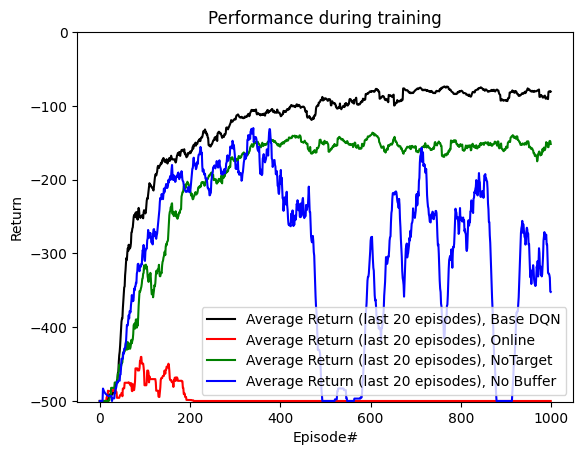

In [201]:
######## PUT YOUR CODE HERE ########
agent_001.make_plot(0, 0, 1, default_scheme=0, movavg_color='black')
agent_002.make_plot(show_returns=0, show_avgret=0, show_movavg=1, default_scheme=0, movavg_color='r')
agent_003.make_plot(0, 0, 1, default_scheme=0, movavg_color='g')
agent_004.make_plot(0, 0, 1, default_scheme=0, movavg_color='b')
######## PUT YOUR CODE HERE ########

In [ ]:
# EVALUATION
# results are to be expected. No buffer makes the trianing unstable, No target network degrades performance but still allows the model to converge,
# and having neither causes the performance to be unstable as well as so bad that it can't converge without staying on one policy for a while to collect consistent feedback.

## Problem 1.3

Select any one hyperparameter of the DeepQLearning agent and study its effect on the agent's performance. You should try at least five different values of this hyperparameter. In a single plot, show the performance of the agent for different values of hyperparameter.  Specifications of the plot
- X axis: Number of Timesteps (0 to 100000)
- Y axis: 20-episode simple moving average of episodic rewards.


In [202]:
######## PUT YOUR CODE HERE ########
# change target network update frequency to know how flexible should the critic be for this task
# baseline value
base_freq = agent_001.target_network_update_frequency
agent_half = DeepQLearning(env, target_network_update_frequency=base_freq//2)
agent_quarter = DeepQLearning(env, target_network_update_frequency=base_freq//4)
agent_double = DeepQLearning(env, target_network_update_frequency=base_freq*2)
agent_four = DeepQLearning(env, target_network_update_frequency=base_freq*4)
######## PUT YOUR CODE HERE ########

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Timestep: 20000, episode reward (moving average, 20 episodes): -390.55
Timestep: 30000, episode reward (moving average, 20 episodes): -252.0
Timestep: 40000, episode reward (moving average, 20 episodes): -175.25
Timestep: 50000, episode reward (moving average, 20 episodes): -161.9
Timestep: 60000, episode reward (moving average, 20 episodes): -138.4
Timestep: 70000, episode reward (moving average, 20 episodes): -117.5
Timestep: 80000, episode reward (moving average, 20 episodes): -102.8
Timestep: 90000, episode reward (moving average, 20 episodes): -100.55
Timestep: 100000, episode reward (moving average, 20 episodes): -82.6
Timestep: 110000, episode reward (moving average, 20 episodes): -79.35
Timestep: 120000, episode reward (moving average, 20 episodes): -90.35
Timestep: 130000, episode reward (moving average, 20 episodes): -84.65
Timestep: 10000, episode reward (moving average, 20 episodes): -500.0
Timestep: 20000, episode reward (moving average, 20 episodes): -417.45
Timestep: 300

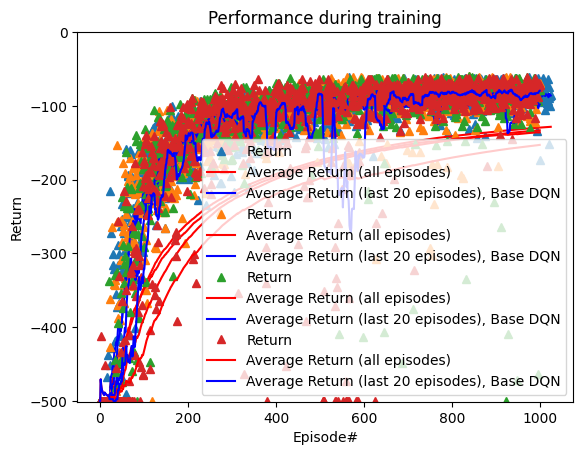

In [204]:
agent_quarter.train(1000, make_plot=True, show_instant=1)
agent_half.train(1000, make_plot=True, show_instant=1)
agent_double.train(1000, make_plot=True, show_instant=1)
agent_four.train(1000, make_plot=True, show_instant=1)

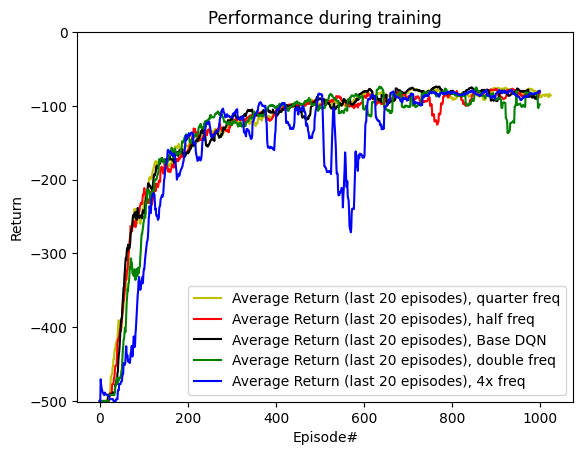

In [206]:
agent_quarter.make_plot(0, 0, 1, default_scheme=0, movavg_color='y', model_label='quarter freq')
agent_half.make_plot(0, 0, 1, default_scheme=0, movavg_color='r', model_label='half freq')
agent_001.make_plot(show_returns=0, show_avgret=0, show_movavg=1, default_scheme=0, movavg_color='k')
agent_double.make_plot(0, 0, 1, default_scheme=0, movavg_color='g', model_label='double freq')
agent_four.make_plot(0, 0, 1, default_scheme=0, movavg_color='b', model_label='4x freq')

In [ ]:
# EVALUATION
# we see here that the change in target network update frequency does not impact the agent's performance too much, perhaps due to the low difficulty of the task
# which is consistent with the agent's ability to still converge as we take away the target network, and to a certain extent, the replay buffer as well.
# Here we see that while the agents all converge to the same mean, increasing the target network update frequency causes the training to have more variance
# this is consistent with the cause -- changing policy more often will introduce more varying results, increasing variance.
# we can increase this update frequency until the target network becomes the q network -- in other words, it ceases to exist.

## Problem 1.4

While applying RL in real world, you may consider the use of off-the-shelf implementation of RL algorithms. The package [Stable Baselines 3](stable-baselines3.readthedocs.io/) aims to provide a set of reliable implementations of RL algorithms in PyTorch.

Familiarize yourself with this package and use its implementation of Deep Q Network to learn the optimal policy for the Acrobot environment.

In [144]:
from stable_baselines3 import DQN

In a single plot, compare the performance of your implementation of the algorithm in Problem 1.1. with the one that you implemented above (Problem 1.4). Specifications of the plot
- X axis: Number of Timesteps (0 to 100000)
- Y axis: 20-episode simple moving average of episodic rewards.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 500      |
|    ep_rew_mean      | -500     |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 445      |
|    time_elapsed     | 4        |
|    total_timesteps  | 2000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 500      |
|    ep_rew_mean      | -500     |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 663      |
|    time_elapsed     | 6        |
|    total_timesteps  | 4000     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 500      |
|    ep_rew_mean      | -500   

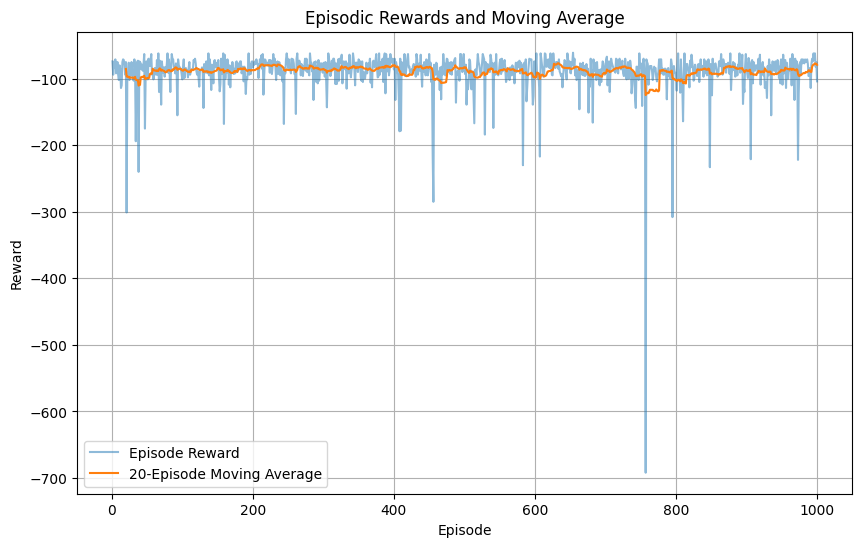

In [189]:
sb3_model = DQN("MlpPolicy", env, verbose=1,
                learning_rate=agent_001.learning_rate,
                buffer_size=agent_001.replay_buffer.buffer_size,
                learning_starts=agent_001.learning_starts_at_step,
                batch_size=agent_001.batch_size,
                gamma=agent_001.gamma,
                train_freq=1,
                gradient_steps=agent_001.num_gradient_updates,
                target_update_interval=agent_001.target_network_update_frequency,
                #exploration_initial_eps=agent_001.initial_epsilon,
                #exploration_final_eps=agent_001.final_epsilon,
                stats_window_size=20
                )

# Variables for tracking rewards
episode_rewards = []
moving_average_rewards = []

# Number of episodes for the moving average
window_size = 20

sb3_model.learn(total_timesteps=100000, log_interval=4)

# Training loop
num_episodes = 1000
for episode in range(num_episodes):
    obs = env.reset()[0]
    #print(obs)
    episode_reward = 0

    while True:
        action, _ = sb3_model.predict(obs)
        obs, reward, done, truncated, _ = env.step(action)
        episode_reward += reward

        if done:
            episode_rewards.append(episode_reward)

            # Calculate the moving average
            if len(episode_rewards) >= window_size:
                moving_average = np.mean(episode_rewards[-window_size:])
                moving_average_rewards.append(moving_average)
                print(episode, "reward = ", episode_reward, ", average = ", moving_average)

            break

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_episodes + 1), episode_rewards, label="Episode Reward", alpha=0.5)
plt.plot(range(window_size, num_episodes + 1), moving_average_rewards, label=f"{window_size}-Episode Moving Average")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.title("Episodic Rewards and Moving Average")
plt.grid()
plt.show()

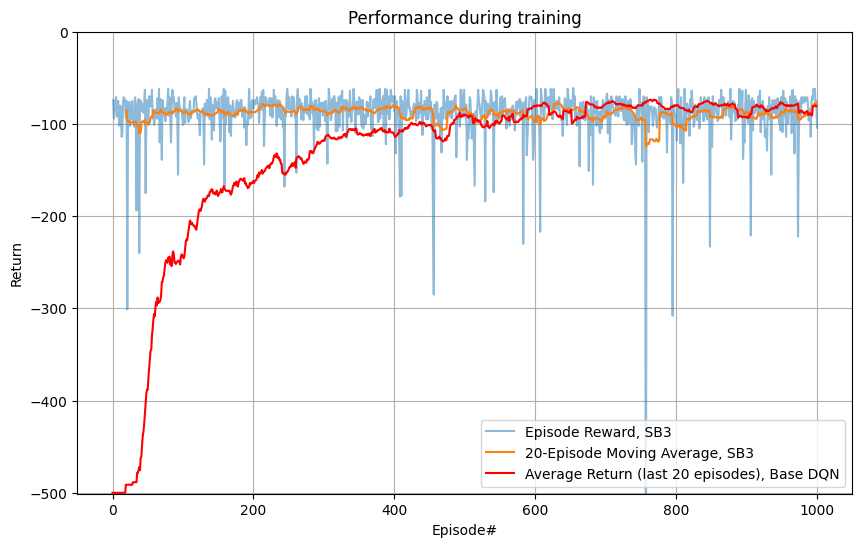

In [207]:
# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_episodes + 1), episode_rewards, label="Episode Reward, SB3", alpha=0.5)
plt.plot(range(window_size, num_episodes + 1), moving_average_rewards, label=f"{window_size}-Episode Moving Average, SB3")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.title("Episodic Rewards and Moving Average")
plt.grid()
agent_001.make_plot(0, 0, 1, default_scheme=0, movavg_color='r')
plt.show()

In [ ]:
# ANSWER TO QUESTION 2.1
# continuous state - continuous action problems, since the formulation of deep Q network assumes discrete actions, as each output node of the Q network corresponds to the probability of one action.